In [7]:
import os
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm

# ---------------------------
# 1. Thư mục dữ liệu gốc & thư mục lưu spectrogram
# ---------------------------
root_dir = "nuhive_processed"       # chứa 3 folder: bee, nobee, noqueen
out_dir = "mel_spectrograms"        # folder lưu kết quả
os.makedirs(out_dir, exist_ok=True)

# ---------------------------
# 2. Chuẩn bị MelSpectrogram transform
# ---------------------------
mel_transform = MelSpectrogram(
    sample_rate=22050,
    n_mels=32,
    n_fft=2048,
    hop_length=512
)
db_transform = AmplitudeToDB()

# ---------------------------
# 3. Lặp qua từng class folder và tạo file .pt
# ---------------------------
label_map = {"bee": 0, "nobee": 1, "noqueen": 2}

for label_name, label_id in label_map.items():
    folder = os.path.join(root_dir, label_name)
    files = [f for f in os.listdir(folder) if f.endswith(".wav")]

    for i, fname in enumerate(tqdm(files, desc=f"Processing {label_name}")):
        filepath = os.path.join(folder, fname)

        # Load audio
        waveform, sr = torchaudio.load(filepath)
        if sr != 22050:
            waveform = torchaudio.functional.resample(waveform, sr, 22050)

        # Convert to MelSpectrogram
        mel_spec = mel_transform(waveform)
        mel_spec_db = db_transform(mel_spec)

        # Ensure shape (1, n_mels, time) thay vì (channels, n_mels, time)
        if mel_spec_db.shape[0] > 1:
            mel_spec_db = mel_spec_db.mean(dim=0, keepdim=True)

        # Lưu file với tên gọn: bee_0001.pt, nobee_0002.pt, ...
        out_name = f"{label_name}_{i:04d}.pt"
        out_path = os.path.join(out_dir, out_name)

        torch.save(
            {
                "spectrogram": mel_spec_db,
                "label": label_id
            },
            out_path
        )

print("MelSpectrograms đã được lưu vào:", out_dir)


Processing noqueen: 100%|██████████| 4861/4861 [00:32<00:00, 151.81it/s]

MelSpectrograms đã được lưu vào: mel_spectrograms


In [8]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# ---------------------------
# 1. Dataset class đọc file .pt khi cần
# ---------------------------
class MelSpectrogramPTDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])   # load .pt khi cần
        spectrogram = data["spectrogram"]    # (1, n_mels, time)
        label = self.labels[idx]
        return spectrogram, label


# ---------------------------
# 2. Chuẩn bị danh sách file + nhãn
# ---------------------------
pt_dir = "mel_spectrograms"  # nơi đã lưu bee_0001.pt, nobee_0002.pt, ...
all_files = [os.path.join(pt_dir, f) for f in os.listdir(pt_dir) if f.endswith(".pt")]

label_map = {"bee": 0, "nobee": 1, "noqueen": 2}
all_labels = []

for f in all_files:
    fname = os.path.basename(f)
    if fname.startswith("bee"):
        all_labels.append(label_map["bee"])
    elif fname.startswith("nobee"):
        all_labels.append(label_map["nobee"])
    elif fname.startswith("noqueen"):
        all_labels.append(label_map["noqueen"])

# ---------------------------
# 3. Stratified Split
# ---------------------------
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels, test_size=0.30, stratify=all_labels, random_state=42
)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42
)

# ---------------------------
# 4. Tạo Dataset và DataLoader
# ---------------------------
train_dataset = MelSpectrogramPTDataset(train_files, train_labels)
val_dataset = MelSpectrogramPTDataset(val_files, val_labels)
test_dataset = MelSpectrogramPTDataset(test_files, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# ---------------------------
# 5. Kiểm tra thử 1 batch
# ---------------------------
for X, y in train_loader:
    print("Batch X shape:", X.shape)  # (batch, 1, n_mels, time)
    print("Batch y shape:", y.shape)  # (batch,)
    break


Train: 9654, Val: 2069, Test: 2069
Batch X shape: torch.Size([16, 1, 32, 87])
Batch y shape: torch.Size([16])


Epoch 1/10 [Train]:   0%|          | 0/604 [00:00<?, ?it/s]

Epoch 1/10 [Val]: 100%|██████████| 130/130 [00:04<00:00, 28.49it/s]


Epoch 1/10 | Train Loss: 0.6277, Train Acc: 0.7212 | Val Loss: 0.4888, Val Acc: 0.7786


Epoch 2/10 [Val]: 100%|██████████| 130/130 [00:03<00:00, 33.52it/s]


Epoch 2/10 | Train Loss: 0.5109, Train Acc: 0.7737 | Val Loss: 0.4792, Val Acc: 0.7772


Epoch 3/10 [Val]: 100%|██████████| 130/130 [00:00<00:00, 136.75it/s]


Epoch 3/10 | Train Loss: 0.4850, Train Acc: 0.7806 | Val Loss: 0.4792, Val Acc: 0.7782


Epoch 4/10 [Val]: 100%|██████████| 130/130 [00:00<00:00, 133.88it/s]


Epoch 4/10 | Train Loss: 0.4633, Train Acc: 0.7930 | Val Loss: 0.4425, Val Acc: 0.8086


Epoch 5/10 [Val]: 100%|██████████| 130/130 [00:00<00:00, 132.15it/s]


Epoch 5/10 | Train Loss: 0.4471, Train Acc: 0.8030 | Val Loss: 0.4299, Val Acc: 0.8130


Epoch 6/10 [Val]: 100%|██████████| 130/130 [00:00<00:00, 135.11it/s]


Epoch 6/10 | Train Loss: 0.4337, Train Acc: 0.8100 | Val Loss: 0.4266, Val Acc: 0.8246


Epoch 7/10 [Val]: 100%|██████████| 130/130 [00:00<00:00, 138.70it/s]


Epoch 7/10 | Train Loss: 0.4225, Train Acc: 0.8154 | Val Loss: 0.4233, Val Acc: 0.8217


Epoch 8/10 [Val]: 100%|██████████| 130/130 [00:01<00:00, 126.34it/s]


Epoch 8/10 | Train Loss: 0.4081, Train Acc: 0.8224 | Val Loss: 0.4353, Val Acc: 0.8236


Epoch 9/10 [Val]: 100%|██████████| 130/130 [00:00<00:00, 131.66it/s]


Epoch 9/10 | Train Loss: 0.4016, Train Acc: 0.8294 | Val Loss: 0.4207, Val Acc: 0.8221


Epoch 10/10 [Val]: 100%|██████████| 130/130 [00:00<00:00, 135.76it/s]


Epoch 10/10 | Train Loss: 0.3986, Train Acc: 0.8267 | Val Loss: 0.4160, Val Acc: 0.8289


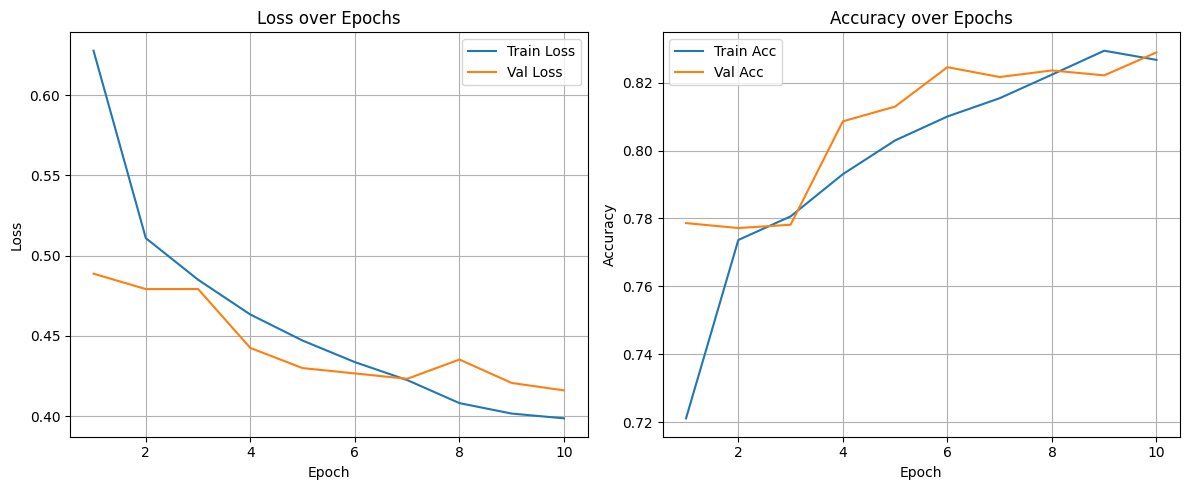

Testing: 100%|██████████| 130/130 [00:01<00:00, 123.62it/s]

✅ Test Accuracy: 0.8241
💾 Model đã được lưu vào audio_cnn_model.pth


In [11]:
import torch.nn as nn
import matplotlib.pyplot as plt

# ============================================================
# 1. Định nghĩa CNN model
# ============================================================
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Pool về 4x4 để flatten cố định
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# ============================================================
# 2. Khởi tạo model, loss, optimizer
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3   # bee, nobee, noqueen
model = AudioCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ============================================================
# 3. Training loop
# ============================================================
num_epochs = 10
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss, correct, total = 0, 0, 0
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        X, y = X.to(device), y.to(device)

        outputs = model(X)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # ---- Validation ----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# ============================================================
# 4. Vẽ biểu đồ Loss & Accuracy
# ============================================================
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss over Epochs"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# ============================================================
# 5. Đánh giá trên test set
# ============================================================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X, y in tqdm(test_loader, desc="Testing"):
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, pred = torch.max(outputs, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)

test_acc = correct / total
print(f"✅ Test Accuracy: {test_acc:.4f}")

# ============================================================
# 6. Lưu model
# ============================================================
torch.save(model.state_dict(), "audio_cnn_model.pth")
print("💾 Model đã được lưu vào audio_cnn_model.pth")
